![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQUXi3mkDlIZMmaGJzZVQnEEC535eNtp3WbO5HzZMxhCcUwucLo)

# **SMS: Spam or Ham (Beginner)**

For my first kernel on Natural Language Processing (NLP), I chose the SMS Spam Collection Dataset.  
It contains  the text of 5572 SMS messages and a label, classifying the message as "spam" or "ham".

In this kernel I explore some common techniques of NLP like:

* **Removing Punctuation and Stopwords**
* **Tokenizer, Bag of words**  
* **Term frequency inverse document frequency (TFIDF)**

Based on these preprocessing, I train 6 different models that classify **unknown** messages as spam or ham. 

* **Naive Bayes Classifier**
* **SVM Classifier**  
* **KNN Classifier**
* **SGD Classifier**
* **Gradient Boosting Classifier**
* **XGBoost Classifier**

For easier handling of the preprocessing steps (for train and test data) and the optimization of different  
models for the same conditions, the classification is done with **Pipelines** including GridSearchCV.  
Finally, for the model evaluation different **metrics** are examined:  
accuracy, precision, recall, fscore, roc_auc

# **Part 0: Imports, define functions** 

## Imports

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import os

## Functions

In [2]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False, ax=ax)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# **Part 1: EDA**

In [3]:
data = pd.read_csv("data/spamHamDataSet.csv",encoding='latin-1')
#cleaning data
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":"label", "v2":"text"})
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data['length'] = data['text'].apply(len)
data.head()

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


### Distribution of the target variable

ham     4825
spam     747
Name: label, dtype: int64

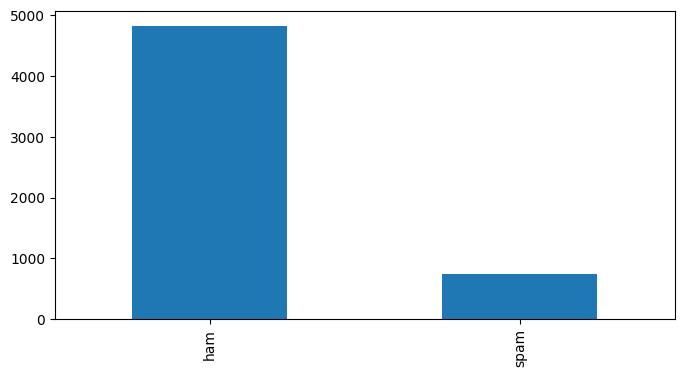

In [4]:
data.label.value_counts().plot.bar(figsize=(8,4))
data.label.value_counts()

# **Part 2: Preprocessing**

**Basic preprocessing for common NLP tasks includes converting text to lowercase and removing punctuation and stopwords.**  
**Further steps, especially for text classification tasks, are:**  
* Tokenization
* Vectorization and 
* TF-IDF weighting  

**Lets apply these approaches on the SMS messages.**

## 2.1 Remove Punctuation and Stopwords

### Punctuation
**We use the punctuation list from the string library:**

In [5]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Stopwords  
from sklearn documentation:  https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words  
Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text,   
and which may be removed to avoid them being construed as signal for prediction.  
Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality.  

Due to the known issues in the ’english’ stop word list of sklearn, we use the stopwords from NLTK:

**NLTK**

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/LFE/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
stopwords.words("english")[100:110]

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

**With the above lists for punctuation characters and stop words, we define a function to remove these from the text**  
**This function also converts all text to lowercase**

In [8]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [9]:
data.head(5)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [10]:
data['text'].apply(remove_punctuation_and_stopwords).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

In [11]:
data.head(5)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


## 2.2 Bag of words with CountVectorizer

### The Bag of Words representation

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction  

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.  
In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

**Tokenization**  
tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.  
**Vectorization**  
counting the occurrences of tokens in each document.  
**TF-IDF**  
normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.  


**Bag of Words**  
In this scheme, features and samples are defined as follows:
each individual token occurrence frequency (normalized or not) is treated as a feature.  
the vector of all the token frequencies for a given document is considered a multivariate sample.  
A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.  
We call vectorization the general process of turning a collection of text documents into numerical feature vectors.   
This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or “Bag of n-grams” representation.  
Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

For futher details and example implementations see:  
https://en.wikipedia.org/wiki/Bag-of-words_model  
https://en.wikipedia.org/wiki/Document-term_matrix  

An Introduction to Bag-of-Words in NLP  
https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428

In this kernel we apply the CountVectorizer from sklearn as BOW model.  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html    
As tokenizer we use the remove_punctuation_and_stopwords function defined above

In [12]:
data.head(5)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])

In [14]:
print(len(bow_transformer.vocabulary_))

9431


In all sms messages bow_transformer counted 9431 different words.

### Applying bow_transformer on all messages

In [15]:
bow_data = bow_transformer.transform(data['text'])

In [22]:
bow_data.shape

(5572, 9431)

In [17]:
bow_data.nnz

49772

**Sparsity: percentage of none zero entries**  
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction  
**Sparsity**  
As most documents will typically use a very small subset of the words used in the corpus,  
the resulting matrix will have many feature values that are zeros (typically more than 99% of them).  
For instance a collection of 10,000 short text documents (such as emails) will use a vocabulary  
with a size in the order of 100,000 unique words in total while each document will use 100 to   
1000 unique words individually.  
In order to be able to store such a matrix in memory but also to speed up algebraic operations matrix / vector,  
implementations will typically use a sparse representation such as available in the scipy.sparse package.


number of none zero entries divided by matrix size  

In [26]:
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )

0.09471444959776236


Around 10% of the matrix are non zeros (=ones)

## 2.3 Term frequency inverse document frequency - TFIDF

### From occurrences to frequencies  
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#from-occurrences-to-frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count values  
than shorter documents, even though they might talk about the same topics.  
To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document  
by the total number of words in the document: these new features are called **tf for Term Frequencies**.  
Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are  
therefore less informative than those that occur only in a smaller portion of the corpus.  
This downscaling is called **tf–idf for “Term Frequency times Inverse Document Frequency”**.

For futher details and example implementations see:  
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

### TfidfTransformer from sklearn
Both tf and tf–idf can be computed as follows using TfidfTransformer:   
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)

In [28]:
data_tfidf = tfidf_transformer.transform(bow_data)

In [29]:
data_tfidf

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [30]:
np.shape(data_tfidf)

(5572, 9431)

## train test split

for TFIDF matrix only

In [31]:
from sklearn.model_selection import train_test_split

data_tfidf_train, data_tfidf_test, label_train, label_test = \
    train_test_split(data_tfidf, data["spam"], test_size=0.3, random_state=5)

In [32]:
data_tfidf_train

<3900x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 35125 stored elements in Compressed Sparse Row format>

In [33]:
data_tfidf_test

<1672x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 14647 stored elements in Compressed Sparse Row format>

for TFIDF matrix and feature "length"

In [34]:
from scipy.sparse import  hstack
X2 = hstack((data_tfidf ,np.array(data['length'])[:,None])).A

In [35]:
X2_train, X2_test, y2_train, y2_test = \
    train_test_split(X2, data["spam"], test_size=0.3, random_state=5)

# Part 3: Classifiers

## 3.1 First test for Classification  

### Naive Bayes Classifier

sparse matrix to matrix

In [36]:
data_tfidf_train = data_tfidf_train.A
data_tfidf_test = data_tfidf_test.A

MNB Model using only TFIDF matrix

In [37]:
spam_detect_model = MultinomialNB().fit(data_tfidf_train, label_train)
pred_test_MNB = spam_detect_model.predict(data_tfidf_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.965311004784689


Our first classifier seems to work well, it has an accuracy of 96.5 % for the test set.  

In [38]:
scaler = MinMaxScaler()
data_tfidf_train_sc = scaler.fit_transform(data_tfidf_train)
data_tfidf_test_sc  = scaler.transform(data_tfidf_test)

MNB Model using only TFIDF matrix, scaled

In [39]:
spam_detect_model_minmax = MultinomialNB().fit(data_tfidf_train_sc, label_train)
pred_test_MNB = spam_detect_model_minmax.predict(data_tfidf_test_sc)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9826555023923444


Applying the min max scaler on the TFIDF matrix improves the performance of the MNB classifier:  
It now has an accuracy of 98.2 % for the test set. 

MNB model with TFIDF matrix and feature "length", unscaled

In [40]:
spam_detect_model_2 = MultinomialNB().fit(X2_train, y2_train)
pred_test_MNB_2 = spam_detect_model_2.predict(X2_test)
acc_MNB_2 = accuracy_score(y2_test, pred_test_MNB_2)
print(acc_MNB_2)

0.8761961722488039


Fitting MNB with the unscaled features TFIDF + length of message decreases performance.  
Lets now check the fit with the scaled features.

In [41]:
X2_tfidf_train = X2_train[:,0:9431]
X2_tfidf_test  = X2_test[:,0:9431]
X2_length_train = X2_train[:,9431]
X2_length_test  = X2_test[:,9431]

In [42]:
scaler = MinMaxScaler()
X2_tfidf_train = scaler.fit_transform(X2_tfidf_train)
X2_tfidf_test  = scaler.transform(X2_tfidf_test)

In [43]:
scaler = MinMaxScaler()
X2_length_train = scaler.fit_transform(X2_length_train.reshape(-1, 1))
X2_length_test  = scaler.transform(X2_length_test.reshape(-1, 1))

In [44]:
X2_train = np.hstack((X2_tfidf_train, X2_length_train))
X2_test  = np.hstack((X2_tfidf_test,  X2_length_test))

MNB model with TFIDF matrix and feature "length", scaled

In [45]:
spam_detect_model_3 = MultinomialNB().fit(X2_train, y2_train)
pred_test_MNB_3 = spam_detect_model_3.predict(X2_test)
acc_MNB_3 = accuracy_score(y2_test, pred_test_MNB_3)
print(acc_MNB_3)

0.9826555023923444


We studied the same classifier, Multinomial Naive Bayes, with different set of features and found that the results vary regarding the accuracy of the predictions.  
